### Code for Lab B3
Margaret Lazzarini
Stellar Atmospheres, Winter 2016

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

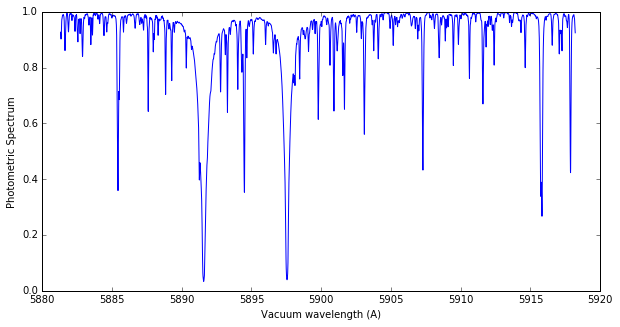

In [5]:
#From README:
#first the frequency, second the deduced telluric
#spectrum, third the observed photospheric spectrum before correction for
#telluric absorption, and fourth the photospheric spectrum corrected for 
#telluric absorption

#The required multiplicative factors to
#correct the observed frequencies to the laboratory scale are 1.0000013 for
#13,500 to 16,000 cm-1, 0.9999981 for 16,000 to 20,000 cm-1, and 1.0000018 for
#20,000 to 28,000 cm-1.

na1d = np.loadtxt('NaD.dat')
wn = np.array(na1d[:,0],dtype='float64')
tell_spec = np.array(na1d[:,1],dtype='float64')
phot_spec = np.array(na1d[:,2],dtype='float64')
phot_spec_corr = np.array(na1d[:,3],dtype='float64')

lam_vac = 1. / wn

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lam_vac*1.0E8, phot_spec)
ax.set_xlabel('Vacuum wavelength (A)')
ax.set_ylabel('Photometric Spectrum')
fig.savefig('32lamvacspectrum')

In [6]:
phot_spec.argsort()[:10]

array([3819, 3820, 3818, 3821, 3817, 3822, 2959, 2960, 3816, 2958])

In [7]:
print 'Vacuum wavelengths at two lowest minima =', lam_vac[4120]*1.0E8, lam_vac[3260]*1.0E8, 'Angstrom'

Vacuum wavelengths at two lowest minima = 5889.48961683 5895.46202117 Angstrom


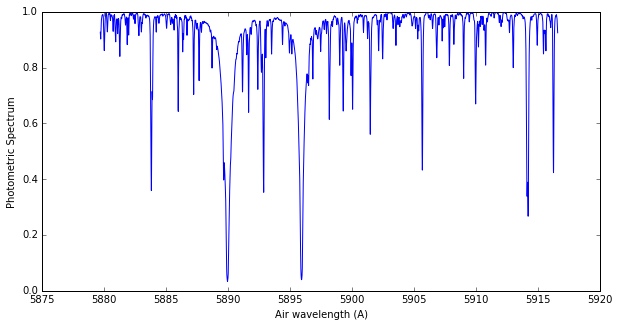

In [8]:
lam_air = lam_vac*1.0E8 * 0.99972683 + 0.0107 - 196.25 / (lam_vac*1.0E8)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lam_air, phot_spec)
ax.set_xlabel('Air wavelength (A)')
ax.set_ylabel('Photometric Spectrum')
plt.savefig('32lamairspectrum')

In [9]:
#Constants:
c = 2.99792458E10
k = 1.380658E-16
hcgs = 6.6260696E-27
m_na = 22.99 * 1.6605 * 10.**(-24.) #g
R = 2.18E-11 #erg
A_na = 1.74E-6
f_lu_D1 = 0.318
f_lu_D2 = 0.631
g_lower_Na = 2.
g_upper_NaD1 = 2.
g_upper_NaD2 = 4.
m_e = 9.109390E-28 #g

In [10]:
def partfunc_Na(T):
    #Sodium partition function from Appendix of Gray 1992, p.22 in Rutten B3
    U = np.zeros(3)
    cc = np.array([0.30955, -0.17778, 1.10594, -2.42847, 1.70721])
    theta = 5040./T
    U[0] = cc[0]+cc[1]*(np.log10(theta))+cc[2]*(np.log10(theta))**2.+cc[3]*(np.log10(theta))**3.+cc[4]*(np.log10(theta))**4.
    U[1] = 1.0
    U[2] = 6.0
    return U

In [11]:
#Suite of functions to return H(a,v)
def H(a, v):
    H = np.exp(-v**2.) + a / (np.pi**0.5 * v**2.)
    return H

def deltalambdaD(center, T, turb):
    first = center / c
    second = ( (2.*k*T)/m_na + turb**2.)**(0.5)
    #print 'delta lambda D = ', first + second
    return first * second

def v(w, middle, T, vturb):
    top = w - middle
    bottom = deltalambdaD(middle, T, vturb)
    #print 'v = ', top/bottom
    return top / bottom

def rbar2(Z, level, l, center):
    #level = 0 for lower, 1 for upper
    hcgs = 6.6260696E-27
    E_inf = 8.2335854e-12 #erg
    E_n = 0
    if level > 0:
        E_n = hcgs*c/center
    n_star2 = R*(Z**2.) / (E_inf - E_n)
    print 'n star = ', n_star2
    t1 = n_star2 / (2.*Z**2.)
    t2 = 5.0*n_star2 + 1.0 - 3.0*l*(l+1.0)
    #print 'rbar2 = ', t1*t2
    print t1*t2
    return t1 * t2

def gamma(P_gas, T, Z, w, center):
    gamma_rad = 6.67E13*(f_lu_D1/(w*1.0E7)**2.)
    tt1 = 6.33 + 0.4*np.log10(rbar2(1.0, 1, 1, center) - rbar2(1.0, 0, 0, center))
    tt2 = np.log10(P_gas) - 0.7*np.log10(T)
    gamma_vdw = 10.**(tt1 + tt2)
    #print 'log gamma vdw = ', tt1+tt2
    #print T, gamma_vdw, gamma_rad
    return gamma_rad + gamma_vdw

def a(w, cent, T, turb, P_gas, Z):
    ttt1 = w**2. / (4* np.pi * c)
    ttt2 = gamma(P_gas, T, Z, w, cent) / deltalambdaD(cent, T, turb)
    #print 'a = ', ttt1*ttt2
    return ttt1 * ttt2

In [43]:
print a(lam_0, lam_0, temp[40], v_turb[40], p_gas_p[40],1)

n star =  2.64769223007
10.9064547878
n star =  2.64769221924
18.8495313291
nan


/Users/mwilde/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in log10


In [12]:
#Suite of functions to return n_e^LTE / N_E
def boltz_Na(T, Z, level):
    r = Z
    s = level
    u = partfunc_Na(T)
    keV = 8.61734E-5
    relnrs = 1./u[r-1]*np.exp(-(s-1)/(keV*T))
    return relnrs

def saha_Na(T, elpress, ionstage):
    kerg = 1.380658E-16
    keV = 8.61734E-5
    hcgs = 6.62607E-27
    elmass = 9.109390E-28
    kevT = keV * T
    kergT = kerg * T
    eldens = elpress/kergT
    chiion = [5.139, 47.29, 71.64]
    u = partfunc_Na(T)
    u = np.append(u, 0)
    sahaconst = ((2.*np.pi*elmass*kergT/(hcgs**2))**(1.5))*2./eldens
    nstage = np.zeros(len(u)+1)
    nstage[0] = 1.
    #print 'sahaconst =', sahaconst, ' u = ', u
    for r in range(0,len(chiion)):
        nstage[r+1] = (nstage[r]*sahaconst*u[r+1])/u[r]*np.exp(-chiion[r]/kevT)
    ntotal = np.sum(nstage)
    nstagerel = nstage/ntotal
    
    return nstagerel[ionstage-1]

def sahabolt_Na(T, elpress, Z, level):
    return saha_Na(T, elpress, Z) * boltz_Na(T,Z,level)

In [42]:
# temp[40], n_electron[40], n_H[40], lam_0, v_turb[40], press[40], p_gas_p[40], Z
print sahabolt_Na(temp[40], n_electron[40]*k*temp[40], 1, 1)

3.66211657528e-07


In [13]:
def extNa(lam, T, n_electron, n_H, lam_0, v_t, press, p_gas_p, Z):
    #Convert inputs into CGS before feeding into sub functions
    v_t_cm = v_t * 1.0E5 #convert from km/s to cm/s
    lam_cm = lam * 1.0E-8 #convert A to cm
    lam_0_cm = lam_0 * 1.0E-8 #convert A to cm
    e_charge = 4.8032068E-10
    
    elpress = n_electron*k*T
    P_g = press * p_gas_p
    term1 = np.sqrt(np.pi) * e_charge**(2.) / (m_e * c)
    term2 = lam_cm**2. / c
    term3 = sahabolt_Na(T, elpress, Z, Z)
    term4 = n_H
    term5 = A_na
    term6 = f_lu_D1
    term7 = H(a(lam_cm, lam_0_cm, T, v_t_cm, P_g, Z),v(lam_cm, lam_0_cm, T, v_t_cm)) / deltalambdaD(lam_0_cm, T, v_t_cm)
    term8 = (1.0 - np.exp(-hcgs*c / (lam_cm*k*T)))
    return term1*term2*term3*term4*term5*term6*term7*term8

In [14]:
#Hminus extinction
def exthmin(wav, T, eldens):
    kcgs=1.380658E-16   #; Boltzmann constant (erg/K; double precision)
    hcgs=6.626076E-27   #; Planck constant (erg s)
    ccgs=2.997929E10
    theta = 5040./T
    elpress = eldens*kcgs*T
    sigmabf1 = 1.99654 - 1.18267E-5*wav+2.64243E-6*wav**2.-4.40524E-10*wav**3.
    sigmabf2 = 3.23992E-14*wav**4.-1.39568E-18*wav**5.+2.78701E-23*wav**6.
    sigmabf = sigmabf1 + sigmabf2
    sigmabf=sigmabf*1.0E-18  #cm^2 per H-min ion
    
    if type(wav) == np.ndarray:
        sigmabf[wav > 16444] = 0. # H-min ionization limit 
    else:
        if wav > 16444:
            sigmabf = 0.0
            
    graysaha=4.158E-10*elpress*np.power(theta,2.5)*np.power(10.,(0.754*theta)) #Gray (8.12)
    kappabf=sigmabf*graysaha                               #per neutral H atom
    kappabf=kappabf*(1.-np.exp(-hcgs*ccgs/(wav*1.0E-8*kcgs*T))) 
    #correct stimulated emission
    
    #evaluate H-min free-free including stimulated emission = Gray p136
    lwav=np.log10(wav)
    f0 =  -2.2763 -1.6850*lwav +0.76661*lwav**2. -0.0533464*lwav**3.
    f1 =  15.2827 -9.2846*lwav +1.99381*lwav**2. -0.142631*lwav**3.
    f2 = -197.789 +190.266*lwav -67.9775*lwav**2. +10.6913*lwav**3. -0.625151*lwav**4.
    ltheta=np.log10(theta)
    kappaff = 1.0E-26*elpress*np.power(10.0,(f0+(f1*ltheta)+(f2*ltheta**2.)))   #Gray (8.13)

    return kappabf+kappaff

In [15]:
def planck(T, wav):
    wavcm = wav * 1.0E-8 #convert from angstroms to cm
    first = (2.0 * hcgs * c**2)/(wavcm**5)
    second = 1.0 / (np.exp((hcgs*c)/(wavcm*k*T))-1)
    return (first*second)

In [21]:
#Load FALC model
falc = np.loadtxt('../HW4/falc.dat',skiprows=4)
h = np.array(falc[:,0],dtype='float64')
tau = np.array(falc[:,1],dtype='float64')
colmass = np.array(falc[:,2],dtype='float64')
temp = np.array(falc[:,3],dtype='float64')
v_turb = np.array(falc[:,4],dtype='float64')
n_H = np.array(falc[:,5],dtype='float64')
n_proton = np.array(falc[:,6],dtype='float64')
n_electron = np.array(falc[:,7],dtype='float64')
press = np.array(falc[:,8],dtype='float64')
p_gas_p = np.array(falc[:,9],dtype='float64')
density = np.array(falc[:,10],dtype='float64')

n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
(50,)


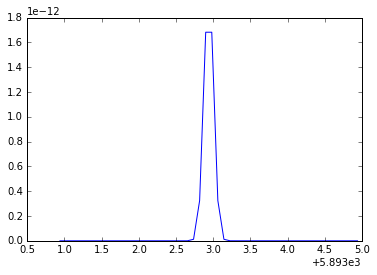

In [41]:
test = 5895.94 
lam = np.linspace(5893.94, 5897.94, 50) #was 500
E = extNa(lam, temp[40], n_electron[40], n_H[40], lam_0, v_turb[40], press[40], p_gas_p[40], Z)
plt.plot(lam,E)
print lam.shape
 

In [32]:
len(h)

80

In [33]:
#print n_H

wl = np.linspace(5893.94, 5897.94, 50) #was 500
lam_0 = 5895.94 #Angstroms for Na D1
Z = 1

lam = wl #Lam array in Angstroms

ext=np.zeros((len(lam),len(n_H)))
tau=np.zeros((len(lam),len(n_H)))
integrand=np.zeros((len(lam),len(n_H)))
intensity=np.zeros(len(lam))

ext_cont=np.zeros((len(lam),len(n_H)))
tau_cont=np.zeros((len(lam),len(n_H)))
integrand_cont=np.zeros((len(lam),len(n_H)))
intensity_cont=np.zeros(len(lam))

for z in range(0,len(lam)):
    for ih in range(1,len(h)):
        #print h[ih], exthmin(lam[z],temp[ih],n_electron[ih])
        #print h[ih], extNa(lam[z], temp[ih], n_electron[ih],  n_H[ih], lam_0, v_turb[ih], press[ih], p_gas_p[ih], Z)
        ext[z,ih]=exthmin(lam[z],temp[ih],n_electron[ih])*(n_H[ih]-n_proton[ih])+0.664E-24*n_electron[ih] + extNa(lam[z], temp[ih], n_electron[ih], n_H[ih], lam_0, v_turb[ih], press[ih], p_gas_p[ih], Z)
        tau[z,ih]=tau[z,ih-1]+0.5*(ext[z,ih]+ext[z,ih-1])*(h[ih-1]-h[ih])*1.0E5
        integrand[z,ih]=planck(temp[ih],lam[z])*np.exp(-tau[z,ih])
        intensity[z]=intensity[z]+0.5*(integrand[z,ih]+integrand[z,ih-1])*(tau[z,ih]-tau[z,ih-1])
        
for z in range(0,len(lam)):
    for ih in range(1,len(h)):
        #print h[ih], exthmin(lam[z],temp[ih],n_electron[ih])
        #print h[ih], extNa(lam[z], temp[ih], n_electron[ih],  n_H[ih], lam_0, v_turb[ih], press[ih], p_gas_p[ih], Z)
        ext_cont[z,ih]=exthmin(lam[z],temp[ih],n_electron[ih])*(n_H[ih]-n_proton[ih])+0.664E-24*n_electron[ih]
        tau_cont[z,ih]=tau_cont[z,ih-1]+0.5*(ext_cont[z,ih]+ext_cont[z,ih-1])*(h[ih-1]-h[ih])*1.0E5
        integrand_cont[z,ih]=planck(temp[ih],lam[z])*np.exp(-tau_cont[z,ih])
        intensity_cont[z]=intensity_cont[z]+0.5*(integrand_cont[z,ih]+integrand_cont[z,ih-1])*(tau_cont[z,ih]-tau_cont[z,ih-1])

n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
39.006458369
n star =  2.64769221924
18.8495313291
n star =  4.48153027712
3

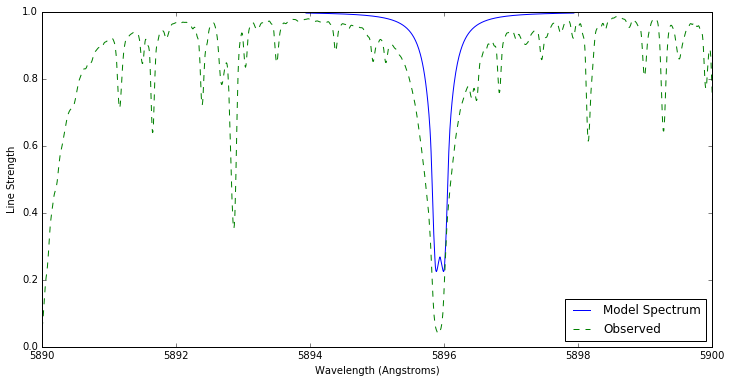

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(lam, intensity/intensity_cont, label='Model Spectrum')
ax.plot(lam_air, phot_spec, linestyle='--', label='Observed')
ax.legend(loc=4)
ax.set_xlim(5890, 5900)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Line Strength')
plt.savefig('ModelSpectrum_finalplot')